In [15]:
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
from termcolor import colored
from gym import wrappers
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env,'./monitor')

[2017-09-20 14:16:59,605] Making new env: CartPole-v0


In [17]:
print(env.observation_space.shape)
print(env.action_space.n)

(4,)
2


In [18]:
s = env.reset()
for i in range(500):
    env.render()
    new_s, r, done, _ = env.step(env.action_space.sample())
    if done:
        break
env.close()

In [25]:
class Agent():
    def __init__(self, epsilon, gamma, lr, batchsize, memory, epsilon_decay):
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.batchsize = batchsize
        self.model = Sequential()
        self.model.add(Dense(32, input_dim=4, activation='relu'))
        self.model.add(Dense(32, activation='relu'))
        self.model.add(Dense(env.action_space.n, activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(lr))
        self.memory = deque(maxlen=memory)
    
    def getAction(self, state):
        # if self.epsilon >= self.epsilon_min:
        if self.epsilon >= np.random.rand():
            return int(np.random.randint(low=0, high=2, size=1))
        else:
            return np.argmax(agent.model.predict(state.reshape(1, 4)))
    
    def getPolicy(self, state):
        return np.argmax(agent.model.predict(state.reshape(1, 4)))
    
    def remember(self, experience):
        self.memory.append(experience)
        
    def train(self):
        index = np.random.choice(len(self.memory), self.batchsize)
        minibatch = [self.memory[i] for i in index]
        # q_fit = []
        # states = []
        for state, action, reward, next_state, done in minibatch:
            q_current = self.model.predict(state.reshape(1,4))
            if done:
                q_target = reward
            else:
                q_target = reward + self.gamma * np.max(self.model.predict(next_state.reshape(1, 4))[0])
            # print(q_current.shape)
            q_current[0][action] = q_target
            # q_fit.append(q_current)
            # states.append(state)
            self.model.fit(x = state.reshape(1, 4), y = q_current, epochs=1, verbose = 0)
        # q_fit = np.reshape(q_fit,(-1,2))
        # states = np.array(states)
        # self.model.fit(x = states, y = q_fit, epochs=1, verbose = 0)
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon*self.epsilon_decay

In [55]:
agent = Agent(1, 0.95, 0.01, 32, 2000, 0.999)

In [56]:
episodes = 2000
t_max = 1000

rewards_list = []

for episode in range(episodes):
    total_reward = 0
    s = env.reset()
    for t in range(t_max):
        a = agent.getAction(s)
        next_s, r, done, _ = env.step(a)
        agent.remember([s,a,r,next_s,done])
        total_reward = total_reward + r
        s = next_s
        if done:
            break
    agent.train()
    rewards_list.append(total_reward)
    if total_reward<150:
        print(colored('episode:{0}, total_reward:{1}, epsilon:{2}'.format(episode+1, total_reward, agent.epsilon),'red'))
    else:
        print(colored('episode:{0}, total_reward:{1}, epsilon:{2}'.format(episode+1, total_reward, agent.epsilon),'green'))

[2017-09-20 14:17:15,764] Starting new video recorder writing to C:\Users\abjilani\Desktop\Projects\Practical RL\week4\monitor\openaigym.video.0.2572.video000000.mp4


DependencyNotInstalled: Found neither the ffmpeg nor avconv executables. On OS X, you can install ffmpeg via `brew install ffmpeg`. On most Ubuntu variants, `sudo apt-get install ffmpeg` should do it. On Ubuntu 14.04, however, you'll need to install avconv with `sudo apt-get install libav-tools`.

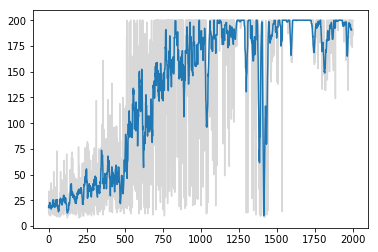

In [47]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

smoothed_rews = running_mean(rewards_list, 10)
plt.plot(rewards_list, color='grey', alpha=0.3)
plt.plot(smoothed_rews)

In [53]:
s = env.reset()
total_reward = 0
for i in range(1000):
    env.render()
    new_s, r, done, _ = env.step(np.argmax(agent.model.predict(s.reshape(1, 4))))
    s = new_s
    total_reward = total_reward + r
    if done:
        print(total_reward)
        break
env.close()

188.0
